In [1]:
import numpy as np

In [32]:
from l0pca import model
import tensorflow as tf

In [140]:
import numpy as np
import tensorflow as tf
data = np.loadtxt('Buettner2015Features@1024.csv', delimiter=',', dtype='object')
gene_names = data[0, 1:]
data = data[1:, 1:].astype(np.float32)
data = tf.constant(data)
cov = tf.linalg.matmul(tf.transpose(data), data) / (data.shape[0] - 1)

In [48]:
l0pca = model.L0PCA()
l0pca.build([100, 1024])

In [42]:
res.run_restore_ops()

In [50]:
l0pca.layers[0].build([100, 1024])

In [52]:
l0pca.load_weights('logs/fit/20221029-174128/model')

In [55]:
l0pca.layers[0].feature_logits

<tf.Variable 'feature_logits:0' shape=(1024,) dtype=float32, numpy=
array([-1.1027327e-37,  1.5477483e-37,  1.0516572e-37, ...,
        2.4936889e-37,  0.0000000e+00,  5.5849165e-38], dtype=float32)>

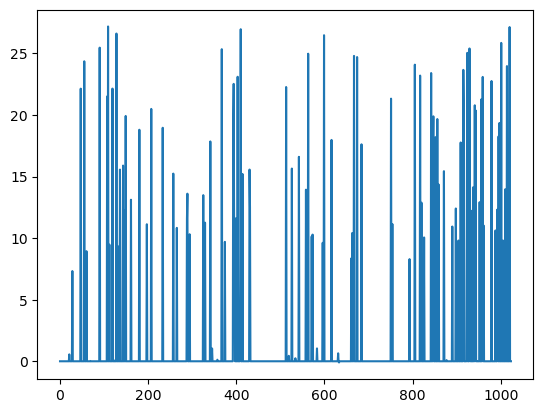

In [94]:
import matplotlib.pyplot as plt
plt.plot(l0pca.layers[0].feature_logits.numpy())
logit = l0pca.layers[0].feature_logits

In [95]:
import tensorflow as tf

In [88]:
tf.nn.softmax(logit) * tf.linalg.norm(tf.math.exp(logit), 1) == np.exp(logit.numpy())

<tf.Tensor: shape=(1024,), dtype=bool, numpy=array([False, False, False, ..., False, False, False])>

In [80]:
(tf.nn.softmax(logit) * tf.linalg.norm(tf.math.exp(logit), 1))[109]

<tf.Tensor: shape=(), dtype=float32, numpy=643493600000.0>

In [81]:
tf.math.exp(logit[109])

<tf.Tensor: shape=(), dtype=float32, numpy=643493600000.0>

In [68]:
tf.nn.softmax(logit)[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.9411223e-13, 2.9411223e-13, 2.9411223e-13, 2.9411223e-13,
       2.9411223e-13], dtype=float32)>

In [69]:
logit[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-1.1027327e-37,  1.5477483e-37,  1.0516572e-37,  3.4169934e-38,
        0.0000000e+00], dtype=float32)>

In [72]:
tf.math.exp(logit)[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 1.], dtype=float32)>

In [73]:
tf.math.reduce_sum(tf.math.exp(logit))

<tf.Tensor: shape=(), dtype=float32, numpy=3400062500000.0>

In [75]:
logit.numpy().argmax()

109

In [82]:
cutoff = 1e-10

In [101]:
logit = logit - tf.cast(tf.math.log(tf.math.reduce_sum(tf.math.exp(logit))), tf.float32)
logit[109]

<tf.Tensor: shape=(), dtype=float32, numpy=-1.6646366>

In [102]:
tf.math.exp(logit[109])

<tf.Tensor: shape=(), dtype=float32, numpy=0.18925942>

In [96]:
logit[109]

<tf.Tensor: shape=(), dtype=float32, numpy=27.190178>

In [98]:
tf.math.log(tf.nn.softmax(l0pca.layers[0].feature_logits)[109])

<tf.Tensor: shape=(), dtype=float32, numpy=-1.6646371>

In [100]:
tf.math.log(tf.math.reduce_sum(tf.math.exp(tf.cast(logit, tf.float64))))

<tf.Tensor: shape=(), dtype=float64, numpy=28.854814989650237>

In [113]:
from numpy import log
from scipy.special import betaln

def binomln(n, k):
    "Log of scipy.special.binom calculated entirely in the log domain"
    return -betaln(1 + n - k, 1 + k) - log(n + 1)

np.exp(binomln(1000, 10))

2.634095604617454e+23

In [119]:
cutoff = -10 * np.log(10)
num_excluded = sum(logit.numpy() < cutoff)
cdf_excluded = np.exp(cutoff * 3 + binomln(num_excluded, 3))
cdf_excluded

1.3148134999997657e-22

In [120]:
np.mean(logit[logit >= cutoff])

-12.0763855

In [124]:
def ensemble_descending_3(logit):
    cutoff = -3 * np.log(10)
    keep_index, = np.where(logit >= cutoff)
    n_keep = len(keep_index)
    probs = []
    inds = []
    for i in range(n_keep):
        for j in range(i + 1, n_keep):
            for k in range(j + 1, n_keep):
                probs.append(logit[keep_index[i]] + logit[keep_index[j]] + logit[keep_index[k]])
                inds.append([keep_index[i], keep_index[j], keep_index[k]])
    probs = np.asarray(probs)
    inds = np.asarray(inds)
    inds = inds[np.argsort(-probs)]
    probs = probs[np.argsort(-probs)]
    return probs, inds

In [125]:
probs, inds = ensemble_descending_3(logit)

In [129]:
sum(np.exp(probs))

0.11201130140438953

In [137]:
inds[0]

array([ 109,  410, 1020])

In [138]:
len(inds)

2600

In [139]:
data_row = np.arange(16)

In [141]:
@tf.function(jit_compile = True)
def gather_cov(cov, batches):
    inds_row = batches[..., :, None, None]
    inds_col = batches[..., None, :, None]
    inds_shape = tf.broadcast_dynamic_shape(
        tf.shape(inds_row), tf.shape(inds_col))
    inds = tf.concat([tf.broadcast_to(inds_row, inds_shape), tf.broadcast_to(inds_col, inds_shape)], axis=-1)
    return tf.gather_nd(cov, inds)

In [160]:
probs[:5]

array([-5.266136 , -5.6172924, -5.7519836, -5.792778 , -5.8411484],
      dtype=float32)

In [169]:
scores = []
for r in range(1024):
    cov_aug = gather_cov(cov, np.c_[inds, np.tile([[r]], [len(inds), 1])])
    evalues, evectors = tf.linalg.eigh(cov_aug)
    scores.append((evectors[:, -1, -1] - tf.math.reduce_min(evectors[:, :-1, -1], axis=1)).numpy())

<AxesSubplot:>

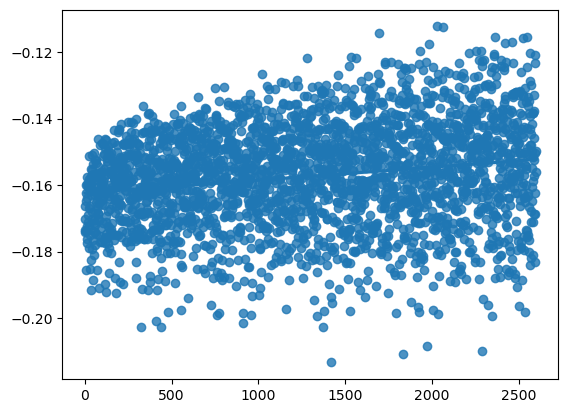

In [172]:
import seaborn as sns
sns.regplot(x=np.arange(len(scores[0])), y=scores[20])

In [276]:
lc = tf.math.log(tf.math.abs(cov))
paircovs = (
    tf.gather_nd(lc, inds[:, :2])
    + tf.gather_nd(lc, inds[:, 1:3])
    + tf.gather_nd(lc, tf.concat([inds[:, 0:1], inds[:, 2:3]], axis=1)))
paircovs = paircovs.numpy()
allcovs = tf.gather_nd(
    lc,
    tf.concat(
        [
            inds[:, None, :2],
            inds[:, None, 1:3],
            tf.concat([inds[:, None, 0:1], inds[:, None, 2:3]], axis=2),
        ],
        axis=1,
    ),
)
allcovs = tf.sort(allcovs, axis=1)

# Linear least squares suggests the median of the three covs, as a predictor of the score!
covfit = functools.reduce(
    tf.linalg.matmul,
    [
        tf.linalg.inv(
            tf.linalg.matmul(tf.transpose(allcovs), allcovs)),
        tf.transpose(allcovs),
        tf.transpose(scores),
    ],
)
tf.math.reduce_mean(covfit, axis=1)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.13552415, 0.6197907 , 0.5421996 ], dtype=float32)>

In [184]:
tf.math.reduce_sum(tf.where(cov < -0.2, 1, 0))

<tf.Tensor: shape=(), dtype=int32, numpy=0>

<AxesSubplot:>

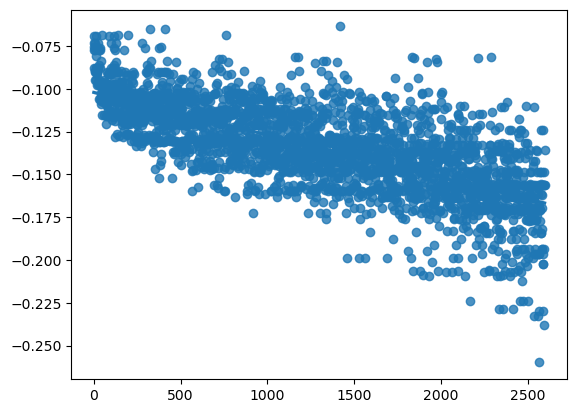

In [277]:
sns.regplot(x=np.arange(len(scores[0])), y=allcovs[:, 1].numpy())

<AxesSubplot:>

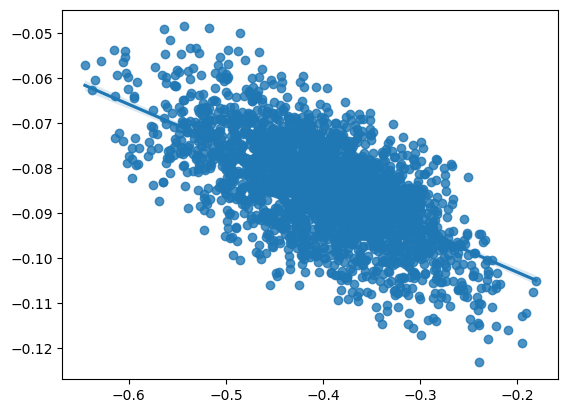

In [255]:
sns.regplot(x=paircovs, y=scores[550])

<AxesSubplot:>

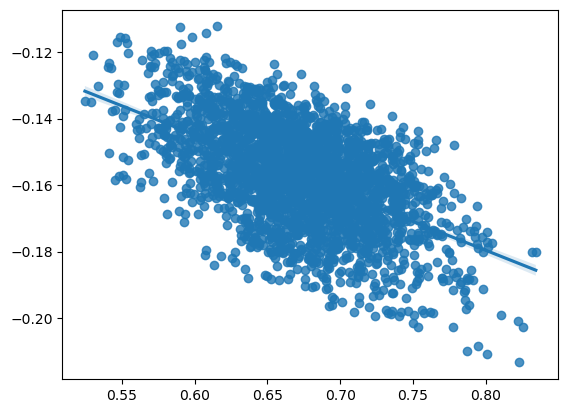

In [252]:
sns.regplot(x=np.exp(paircovs), y=scores[20])

In [188]:
import sklearn.neighbors

In [189]:
len(scores[0])

2600

In [250]:
import functools
x_bucket = np.linspace(0., 2600., 11)
y_bucket = np.linspace(-0.8, 0., 11)
bucket_stat = np.zeros((10, 10))
i = 20
for ind1, (xmin, xmax) in enumerate(zip(x_bucket[:-1], x_bucket[1:])):
    for ind2, (ymin, ymax) in enumerate(zip(y_bucket[:-1], y_bucket[1:])):
        all_x = np.arange(2600)
        logical_mask = functools.reduce(np.logical_and, [xmin <= all_x, all_x < xmax, ymin <= paircovs, paircovs < ymax])
        bucket_stat[ind2, ind1] = np.mean(scores[i][logical_mask])

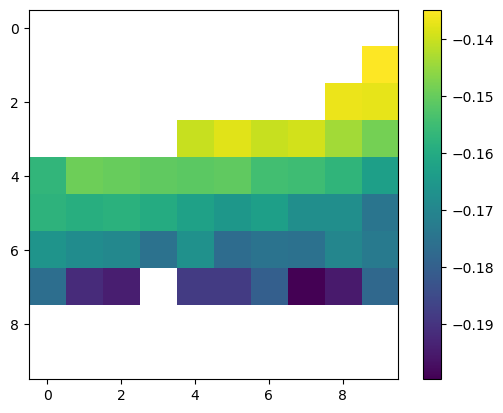

In [251]:
plt.imshow(bucket_stat)
plt.colorbar()

In [238]:
sum(functools.reduce(np.logical_and, [xmin <= all_x, all_x < xmax, ymin <= paircovs, paircovs < -0.2]))

260

In [214]:
xmax

260.0

In [215]:
ymin, ymax

(-0.8, -0.7200000000000001)

In [233]:
sum(logical_mask)

0

In [282]:
import scipy.stats
scipy.stats.mode(allcovs[:, 1].numpy().astype(np.float16))

/var/folders/_7/nzfm900d60v07y_zrq435hdr0000gn/T/ipykernel_64065/247412839.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  scipy.stats.mode(allcovs[:, 1].numpy().astype(np.float16))


ModeResult(mode=array([-0.11395], dtype=float16), count=array([30]))

In [354]:
scoresamp = scores[45][allcovs[:, 1].numpy().astype(np.float16) == -0.11395]

<AxesSubplot:ylabel='Density'>

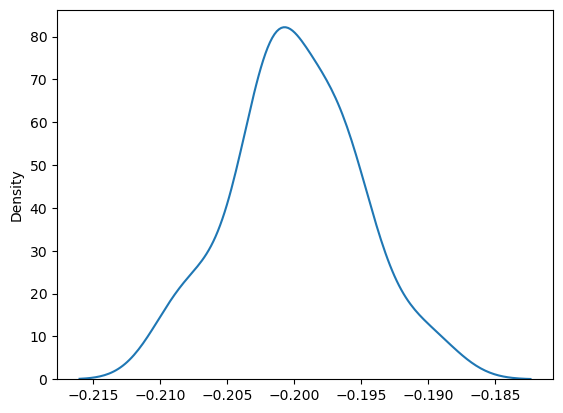

In [355]:
sns.kdeplot(scoresamp)

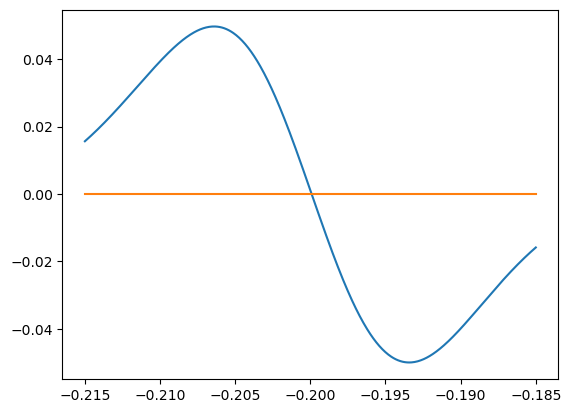

In [358]:
w = 0.005
xs = np.linspace(-0.215, -0.185, 600)[None, :]
ys = (
    -(xs - scoresamp[:, None]) * np.exp(-(xs - scoresamp[:, None]) ** 2 / 2 / w ** 2)
).sum(axis=0)
norm_d1 = ys
plt.plot(xs[0, :], ys)
plt.plot(xs[0, :], np.zeros_like(ys))

In [359]:
ys = (
    ((xs - scoresamp[:, None]) ** 2 - w ** 2) * np.exp(-(xs - scoresamp[:, None]) ** 2 / 2 / w ** 2)
).sum(axis=0)
norm_d2 = ys
# plt.plot(xs[0, :], ys)

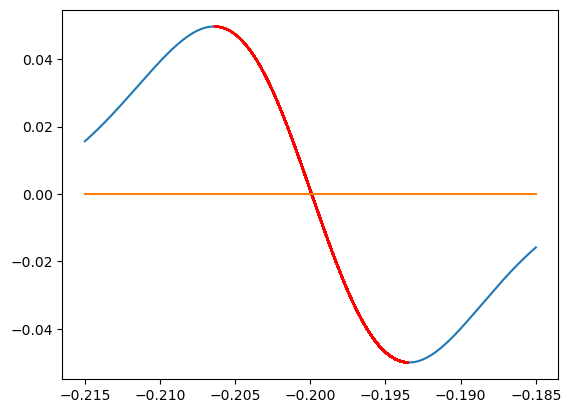

In [360]:
plt.plot(xs[0, :], norm_d1)
for index in range(len(norm_d2)):
    if norm_d2[index] < 0:
        start_index = index
        while index < len(norm_d2) and norm_d2[index] < 0:
            index += 1
        plt.plot(xs[0, start_index:index-1], norm_d1[start_index:index-1], 'red')
plt.plot(xs[0, :], np.zeros_like(ys))

In [297]:
import sklearn.mixture
dist = sklearn.mixture.GaussianMixture(2)
dist.fit(scoresamp.reshape([-1, 1]))

AttributeError: 'NoneType' object has no attribute 'split'

<AxesSubplot:ylabel='Density'>

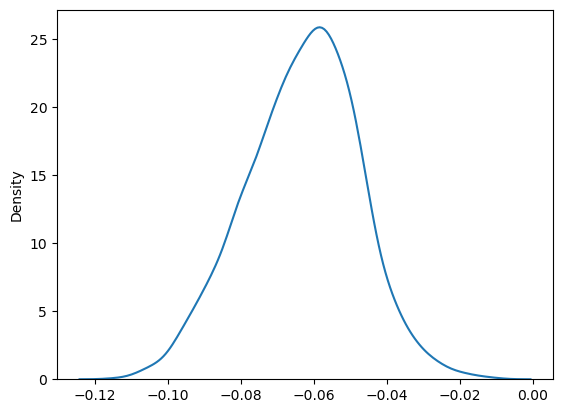

In [290]:
sns.kdeplot(scores[985])